In [1]:
import pandas as pd
import numpy as np
import keras
import cv2
import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, MaxPool2D
from keras.losses import CategoricalCrossentropy
from keras.regularizers import l1,l2
from keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
# from tensorflow.keras.models import Sequential, Model
# from tensorflow import keras
from tensorflow.keras.layers import Input #, Concatenate
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping

import sklearn.metrics as metrics
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator

annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)

2024-07-07 21:27:07.899507: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 21:27:07.899635: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 21:27:08.079883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define the directory containing the original images
original_dir = '/kaggle/input/osteoporosis-knee-xray-dataset/normal/normal'
aug_dir = '/kaggle/working/normal'

if not os.path.exists(aug_dir):
    os.makedirs(aug_dir)

# Function to perform augmentation on an image
def augment_image(image):
    # Example augmentations: flip horizontally, flip vertically, and rotate by 45 degrees
    augmented_images = [cv2.flip(image, 1),  # Horizontal flip
                        cv2.flip(image, 0),  # Vertical flip
                        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
                        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
                        cv2.rotate(image, cv2.ROTATE_180)
                       ]
    
    return augmented_images

# Loop through each image in the original directory
for filename in os.listdir(original_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.JPEG'):
        # Read the image
        img = cv2.imread(os.path.join(original_dir, filename))
        
        # Perform augmentation
        augmented_images = augment_image(img)
        
        # Save augmented images back to the same directory
        for idx, augmented_img in enumerate(augmented_images):
            # Construct the new filename
            new_filename = os.path.splitext(filename)[0] + '_augmented_' + str(idx) + os.path.splitext(filename)[1]
            # Save the augmented image
            cv2.imwrite(os.path.join(aug_dir, new_filename), augmented_img)

print("Augmentation complete.")

Augmentation complete.


In [3]:
# Define the directory containing the original images
original_dir = '/kaggle/input/osteoporosis-knee-xray-dataset/osteoporosis/osteoporosis'
aug_dir = '/kaggle/working/osteoporosis'

if not os.path.exists(aug_dir):
    os.makedirs(aug_dir)

# Function to perform augmentation on an image
def augment_image(image):
    # Example augmentations: flip horizontally, flip vertically, and rotate by 45 degrees
    augmented_images = [cv2.flip(image, 1),  # Horizontal flip
                        cv2.flip(image, 0),  # Vertical flip
                        cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE),
                        cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE),
                        cv2.rotate(image, cv2.ROTATE_180)
                       ]
    
    return augmented_images

# Loop through each image in the original directory
for filename in os.listdir(original_dir):
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.JPEG'):  # Adjust as per your image file extensions
        # Read the image
        img = cv2.imread(os.path.join(original_dir, filename))
        
        # Perform augmentation
        augmented_images = augment_image(img)
        
        # Save augmented images back to the same directory
        for idx, augmented_img in enumerate(augmented_images):
            # Construct the new filename
            new_filename = os.path.splitext(filename)[0] + '_augmented_' + str(idx) + os.path.splitext(filename)[1]
            # Save the augmented image
            cv2.imwrite(os.path.join(aug_dir, new_filename), augmented_img)

print("Augmentation complete.")

Augmentation complete.


In [4]:
import os
import pandas as pd

healthy_dirs = [
    r'/kaggle/working/normal'
]

osteoporosis_dirs = [
    r'/kaggle/working/osteoporosis'
]

filepaths = []
labels = []
dict_lists = [healthy_dirs, osteoporosis_dirs]
class_labels = ['Healthy', 'Osteoporosis']

for i, dir_list in enumerate(dict_lists):
    for j in dir_list:
        flist = os.listdir(j)
        for f in flist:
            fpath = os.path.join(j, f)
            filepaths.append(fpath)
            labels.append(class_labels[i])

Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
knee_osteoporosis_data = pd.concat([Fseries, Lseries], axis=1)
knee_osteoporosis_df = pd.DataFrame(knee_osteoporosis_data)
print(knee_osteoporosis_df.head())
print(knee_osteoporosis_df["labels"].value_counts())

                                      filepaths   labels
0   /kaggle/working/normal/164n_augmented_2.png  Healthy
1  /kaggle/working/normal/26nn_augmented_0.JPEG  Healthy
2   /kaggle/working/normal/91n_augmented_2.JPEG  Healthy
3     /kaggle/working/normal/33_augmented_0.png  Healthy
4    /kaggle/working/normal/150_augmented_2.png  Healthy
labels
Healthy         930
Osteoporosis    930
Name: count, dtype: int64


In [5]:
knee_osteoporosis_df.shape

(1860, 2)

In [6]:
train_images, test_images = train_test_split(knee_osteoporosis_df, test_size=0.3, random_state=42)
train_set, val_set = train_test_split(knee_osteoporosis_df, test_size=0.2, random_state=42)

# train_images, temp_images = train_test_split(knee_osteoporosis_df, test_size=0.4, random_state=42)
# test_images, val_set = train_test_split(temp_images, test_size=0.5, random_state=42)

In [7]:
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input)
train = image_gen.flow_from_dataframe(dataframe= train_images,x_col="filepaths",y_col="labels",
                                      target_size=(224,224),
                                      color_mode='rgb',
                                      class_mode="categorical", #used for Sequential Model
                                      batch_size=2,
                                      shuffle=False            #do not shuffle data
                                     )
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(224,224),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=2,
                                     shuffle= False
                                    )
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(224,224),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=2,
                                    shuffle=False
                                   )

Found 1302 validated image filenames belonging to 2 classes.
Found 558 validated image filenames belonging to 2 classes.
Found 372 validated image filenames belonging to 2 classes.


In [8]:
def show_knee_images(image_gen):
    test_dict = test.class_indices
    classes = list(test_dict.keys())
    images, labels=next(image_gen) # get a sample batch from the generator
    plt.figure(figsize=(20,20))
    length = len(labels)
    if length<25:
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5,5,i+1)
        image=(images[i]+1)/2 #scale images between 0 and 1
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color="green",fontsize=16)
        plt.axis('off')
    plt.show()

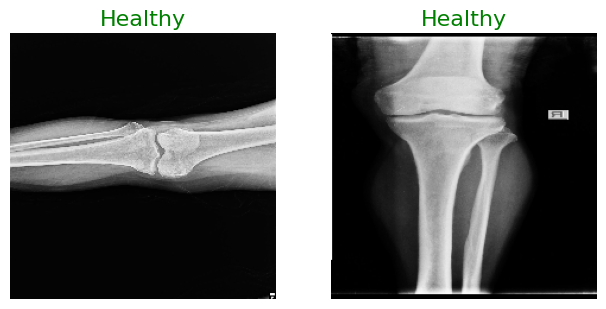

In [9]:
show_knee_images(train)

In [10]:
# Function to create a simple CNN model
def create_cnn_model():
    model = keras.models.Sequential([
        Conv2D(filters=32, kernel_size=(8, 8), strides=(3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(3, 3)),

        Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),

        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(2, activation='softmax')
    ])

#     model.compile(optimizer=Adam(learning_rate=learning_rate), 
#                   loss='categorical_crossentropy',
#                   metrics=['accuracy'])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.optimizers.SGD(learning_rate=0.0001),
        metrics=['accuracy'])

    model.summary()
    return model


# Draw Learning curve
def learning_curve(hist):
    #Create a function to draw learning curves
    # This will help you to just call this function in future for drawing the learning curves
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()
    

def visualize_image_counts(root_directory):
    # Initialize dictionaries to store counts
    directory_counts = {}

    # Traverse the root directory
    for dirpath, dirnames, filenames in os.walk(root_directory):
        # Count the number of image files in each directory
        image_files = [f for f in filenames if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
        directory_counts[dirpath.split("/")[-1]] = len(image_files)

    # Filter out directories without images
    directory_counts = {k: v for k, v in directory_counts.items() if v > 0}

    # Visualize the counts
    directories = list(directory_counts.keys())
    counts = list(directory_counts.values())
    
    # define Seaborn color palette to use 
    palette_color = sns.color_palette('bright') 

    # plotting data on chart 
    plt.pie(counts, labels=directories, colors=palette_color,autopct='%.0f%%', 
            shadow=True) 
    plt.legend(loc='center right',  bbox_to_anchor=(1.6, 0.5))

    # displaying chart 
    plt.show() 
    
    
# Function to fine-tune applicatoin model
def keras_app_model(base_model, dropout=0.1, learning_rate=0.0001):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    predictions = Dense(2, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # Fine-tune optimizer and learning rate
    optimizer = Adam(learning_rate=learning_rate)  # Adjust learning rate as needed
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model


def view_classification_report(model, test, train, test_images):
    pred = model.predict(test)
    pred = np.argmax(pred, axis=1) # pick class with highest  probability

    labels = (train.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred2 = [labels[k] for k in pred]
    
    y_test = test_images.labels # set y_test to the expected output
    print(classification_report(y_test, pred2))
    print("Accuracy of the Model:","{:.1f}%".format(accuracy_score(y_test, pred2)*100))

In [11]:
cnn_model = create_cnn_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 73, 73, 32)     │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 73, 73, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 73, 73, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 73, 73, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 24, 24, 64)     │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 24, 24, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 6, 6, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 3, 3, 128)      │       147,58

 Total params: 721,826 (2.75 MB)

 Trainable params: 720,226 (2.75 MB)

 Non-trainable params: 1,600 (6.25 KB)

In [12]:
cnn_history = cnn_model.fit(train, 
                    epochs=20, 
                    validation_data=val, 
                    verbose=1,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                mode='max',
                                                patience=6, 
                                                restore_best_weights=True)])

# Save the model
cnn_model.save('cnn_model.keras')

Epoch 1/20
  4/651 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.0312 - loss: 1.5242       

I0000 00:00:1720387736.159490     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


651/651 ━━━━━━━━━━━━━━━━━━━━ 58s 71ms/step - accuracy: 0.5069 - loss: 0.7868 - val_accuracy: 0.5699 - val_loss: 0.6848
Epoch 2/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 45s 69ms/step - accuracy: 0.5407 - loss: 0.7430 - val_accuracy: 0.6371 - val_loss: 0.6426
Epoch 3/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.5932 - loss: 0.6874 - val_accuracy: 0.6344 - val_loss: 0.6503
Epoch 4/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.5813 - loss: 0.7099 - val_accuracy: 0.6452 - val_loss: 0.6413
Epoch 5/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.6006 - loss: 0.6839 - val_accuracy: 0.6855 - val_loss: 0.6076
Epoch 6/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 44s 68ms/step - accuracy: 0.6314 - loss: 0.6538 - val_accuracy: 0.6694 - val_loss: 0.6165
Epoch 7/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 45s 68ms/step - accuracy: 0.6399 - loss: 0.6398 - val_accuracy: 0.6478 - val_loss: 0.6499
Epoch 8/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 44s 67ms/step - accuracy: 0.6917 - loss: 0.5825 - val_accurac

In [13]:
cnn_model.evaluate(test, verbose=1)

279/279 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.7754 - loss: 0.5858


[0.5672926306724548, 0.7706093192100525]

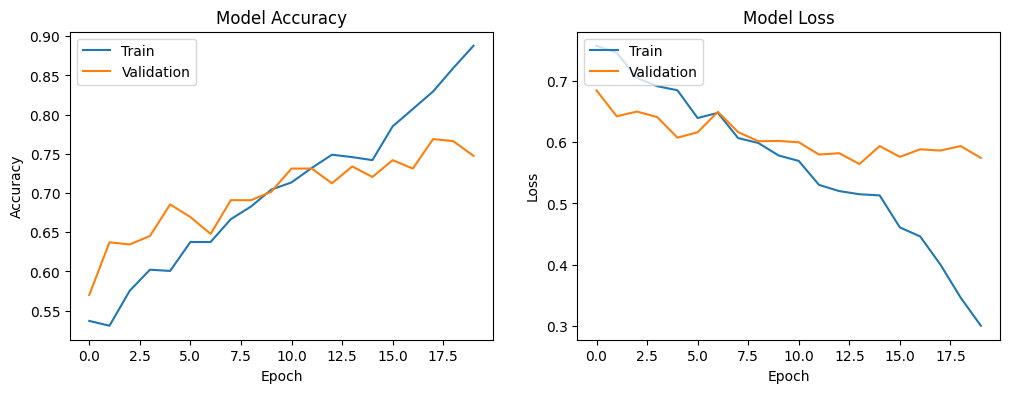

In [32]:
learning_curve(cnn_history)

In [37]:
view_classification_report(cnn_model, test, train, test_images)

279/279 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step
              precision    recall  f1-score   support

     Healthy       0.87      0.64      0.73       277
Osteoporosis       0.72      0.90      0.80       281

    accuracy                           0.77       558
   macro avg       0.79      0.77      0.77       558
weighted avg       0.79      0.77      0.77       558

Accuracy of the Model: 77.1%


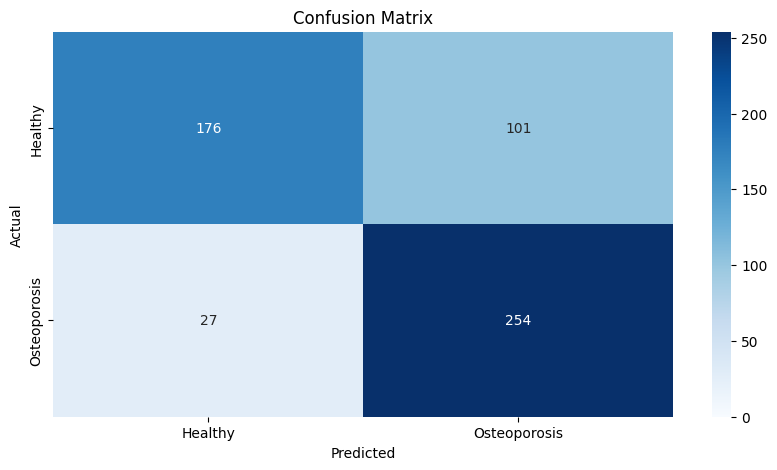

In [16]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix

# # Define the class labels
# class_labels = ['Healthy', 'Osteoporosis']

# # Calculate the confusion matrix
# cm = confusion_matrix(y_test, pred2)

# # Create a figure and plot the confusion matrix as a heatmap
# plt.figure(figsize=(10, 5))
# sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# # Set tick labels and axis labels
# plt.xticks(ticks=[0.5, 1.5], labels=class_labels)
# plt.yticks(ticks=[0.5, 1.5], labels=class_labels)
# plt.xlabel("Predicted")
# plt.ylabel("Actual")

# # Set the title
# plt.title("Confusion Matrix")

# # Show the plot
# plt.show()

In [25]:
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
input_shape = (224,224,3)
# Load pre-trained InceptionResNetV2 model
base_InceptionResNetV2_model = InceptionResNetV2(weights='imagenet', 
                                                 include_top=False, 
                                                 input_shape=input_shape)

# Fine-tune InceptionResNetV2 model
InceptionResNetV2_model = keras_app_model(base_InceptionResNetV2_model)

# Train InceptionResNetV2 model
InceptionResNetV2_hist = InceptionResNetV2_model.fit(
    train, 
    epochs=20, 
    batch_size=8, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
InceptionResNetV2_model.save('InceptionResNetV2_model.h5')

Epoch 1/20
  1/651 ━━━━━━━━━━━━━━━━━━━━ 31:28:57 174s/step - accuracy: 0.5000 - loss: 0.7900

W0000 00:00:1720389121.686333     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6340 - loss: 0.6861

W0000 00:00:1720389195.083610     140 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


651/651 ━━━━━━━━━━━━━━━━━━━━ 259s 130ms/step - accuracy: 0.6341 - loss: 0.6861 - val_accuracy: 0.6371 - val_loss: 3.1352
Epoch 2/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - accuracy: 0.7411 - loss: 0.5023 - val_accuracy: 0.6129 - val_loss: 48.5636
Epoch 3/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - accuracy: 0.8310 - loss: 0.3758 - val_accuracy: 0.7231 - val_loss: 0.5068
Epoch 4/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - accuracy: 0.8887 - loss: 0.2569 - val_accuracy: 0.7258 - val_loss: 10.5832
Epoch 5/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 71s 109ms/step - accuracy: 0.9365 - loss: 0.1686 - val_accuracy: 0.7097 - val_loss: 0.6880
Epoch 6/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 109ms/step - accuracy: 0.9494 - loss: 0.1293 - val_accuracy: 0.6720 - val_loss: 7.7586
Epoch 7/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - accuracy: 0.9635 - loss: 0.1049 - val_accuracy: 0.7419 - val_loss: 0.8632
Epoch 8/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 72s 110ms/step - accuracy: 0.9641 - loss: 0.0946 - 

In [26]:
# Measure test accuracy
scores = InceptionResNetV2_model.evaluate(test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

279/279 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - accuracy: 0.7993 - loss: 0.7987
Test Accuracy: 82.97%


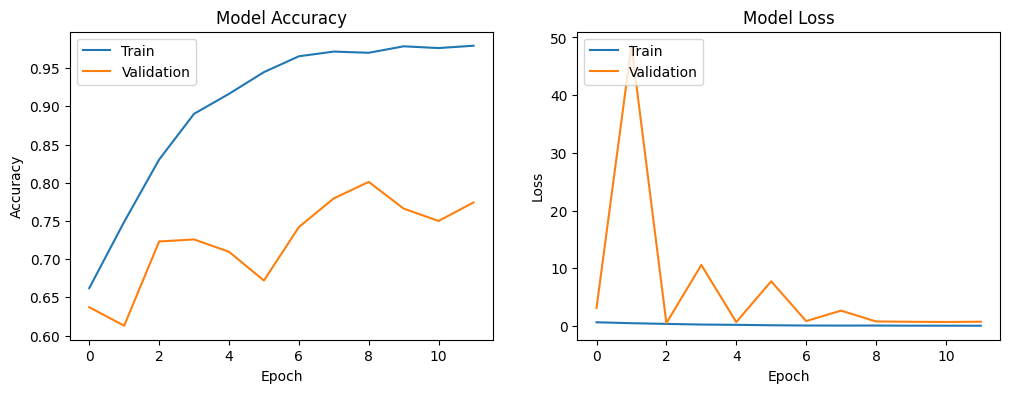

In [27]:
learning_curve(InceptionResNetV2_hist)

In [38]:
view_classification_report(InceptionResNetV2_model, test, train, test_images)

  5/279 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step

W0000 00:00:1720391485.105308     138 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


279/279 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step
              precision    recall  f1-score   support

     Healthy       0.86      0.78      0.82       277
Osteoporosis       0.80      0.88      0.84       281

    accuracy                           0.83       558
   macro avg       0.83      0.83      0.83       558
weighted avg       0.83      0.83      0.83       558

Accuracy of the Model: 83.0%


In [29]:
# Load pre-trained ResNet50 model
base_resnet50_model = ResNet50(weights='imagenet', include_top=False, 
                               input_shape=input_shape)

# Fine-tune ResNet50 model
resnet50_model = keras_app_model(base_resnet50_model)

# Train ResNet50 model
resnet50_hist = resnet50_model.fit(
    train, 
    epochs=20, 
    batch_size=8, 
    validation_data=val,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", 
                                                patience=3, 
                                                restore_best_weights=True)]
)

# Save the model
resnet50_model.save('resnet50_model.h5')

Epoch 1/20
  3/651 ━━━━━━━━━━━━━━━━━━━━ 41s 64ms/step - accuracy: 0.0556 - loss: 1.0026      

W0000 00:00:1720390131.902706     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


651/651 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6406 - loss: 0.7054

W0000 00:00:1720390174.740074     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


651/651 ━━━━━━━━━━━━━━━━━━━━ 113s 81ms/step - accuracy: 0.6407 - loss: 0.7054 - val_accuracy: 0.5618 - val_loss: 0.8473
Epoch 2/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.7891 - loss: 0.4700 - val_accuracy: 0.7823 - val_loss: 0.7213
Epoch 3/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.8932 - loss: 0.2677 - val_accuracy: 0.7769 - val_loss: 0.6232
Epoch 4/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9142 - loss: 0.1926 - val_accuracy: 0.7715 - val_loss: 0.6074
Epoch 5/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 48s 73ms/step - accuracy: 0.9402 - loss: 0.1586 - val_accuracy: 0.7446 - val_loss: 0.7015


In [30]:
# Measure test accuracy
scores = resnet50_model.evaluate(test, verbose=1)
print("Test Accuracy: %.2f%%" % (scores[1] * 100))

279/279 ━━━━━━━━━━━━━━━━━━━━ 14s 51ms/step - accuracy: 0.7821 - loss: 0.7362
Test Accuracy: 76.16%


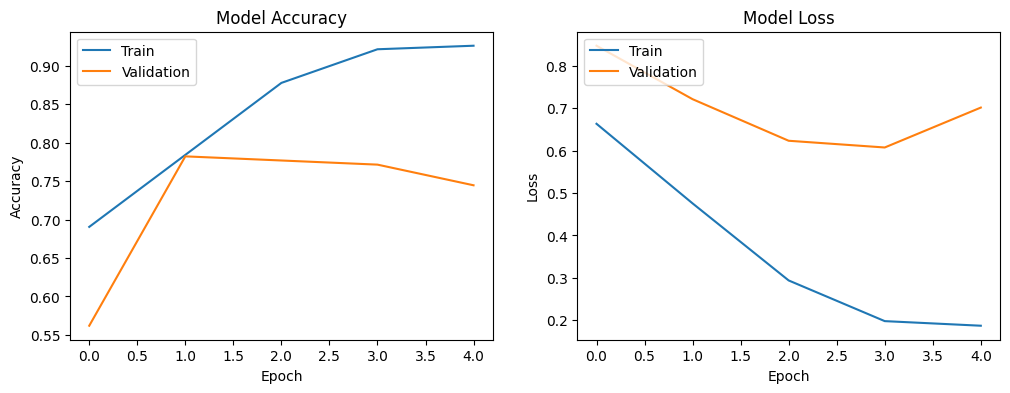

In [31]:
learning_curve(resnet50_hist)

In [39]:
view_classification_report(resnet50_model, test, train, test_images)

  5/279 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step

W0000 00:00:1720391537.425152     141 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


279/279 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step
              precision    recall  f1-score   support

     Healthy       0.77      0.73      0.75       277
Osteoporosis       0.75      0.79      0.77       281

    accuracy                           0.76       558
   macro avg       0.76      0.76      0.76       558
weighted avg       0.76      0.76      0.76       558

Accuracy of the Model: 76.2%
